In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import os

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 1])
        image = Image.open(img_path).convert("RGB")  # Ensure images are RGB
        time = self.data.iloc[idx, 2]  # Convert label to integer
        minute = int(time[-2:])
        hr = int(time[:-3])
        label = hr*12+minute//5 - 12
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),           # Convert image to PyTorch tensor
    # Add more transformations as needed
])

# # Path to the CSV file
csv_file_train = "Naman/rotated_clocks/clocks.csv"
csv_file_test = "Naman/rotated_clocks/new_clock.csv"
# # Path to the folder containing images
root_dir = "Naman/rotated_clocks"

# Create the custom dataset
train_dataset = CustomDataset(csv_file=csv_file_train, root_dir=root_dir, transform=transform)
test_dataset = CustomDataset(csv_file=csv_file_test, root_dir=root_dir, transform=transform)

# # Example usage of the dataset
image, label = train_dataset[0]
print("Label:", label)
print("Image shape:", image.shape)




Label: 0
Image shape: torch.Size([3, 224, 224])


0


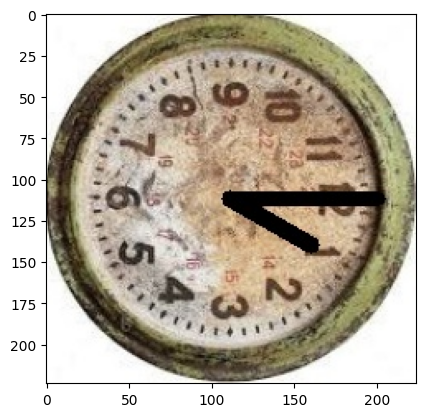

In [2]:
i=4
inp = train_dataset[i][0]
print(train_dataset[i][1])
plt.imshow(inp.permute(1,2,0))

In [3]:

# Define the size of the training and testing sets
# train_size = int(0.7 * len(custom_dataset))
# test_size = len(custom_dataset) - train_size

# Split the dataset randomly into training and testing sets
# train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size],generator=torch.Generator().manual_seed(42))
# train_dataset = custom_dataset
labels_array=set()
for i in range(len(train_dataset)):
    temp = train_dataset.__getitem__(i)[1]
    labels_array.add(temp)
    

print(len(labels_array), min(labels_array), max(labels_array))

# Example of accessing the length of the train and test datasets
print("Training dataset size:", len(train_dataset))
# print("Testing dataset size:", len(test_dataset))




# Example usage of the dataset
# Access the first image and its label
image, label = train_dataset[0]
print("Label:", label)
print("Image shape:", image.shape)

# Create a DataLoader to load the dataset in batches
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Example usage of the data loader
for images, labels in train_data_loader:
    # Training loop or any other processing here
    print("Batch Images shape:", images.shape)
    print("Batch Labels:", labels)
    break  # Break after the first batch

144 0 143
Training dataset size: 11519
Label: 0
Image shape: torch.Size([3, 224, 224])
Batch Images shape: torch.Size([32, 3, 224, 224])
Batch Labels: tensor([ 81, 128, 114, 127, 135, 127,  62,  88,  34, 130,  54,  21,   9,  59,
        102,  43,  74,  76,  75,  72,  34,  82, 101, 112,  95,  92, 117,   4,
         97,  82,  82,  48])


tensor(15)


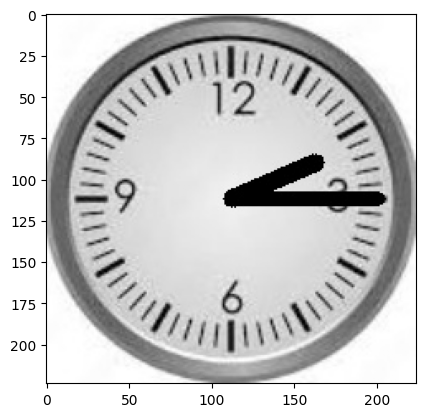

In [4]:
for inputs,labels in test_data_loader:
    x = inputs[0]
    y = labels[0]

    plt.imshow(x.permute(1,2,0))
    print(y)
    break

1


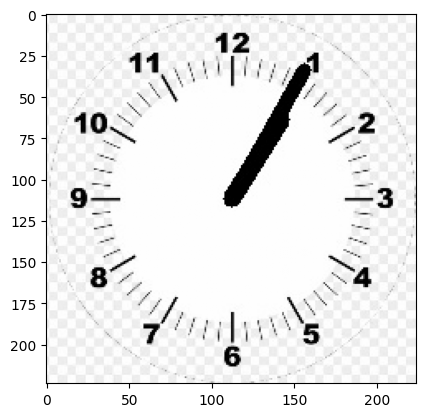

In [5]:
i=13
inp = test_dataset.__getitem__(i)[0]
print(test_dataset.__getitem__(i)[1])
plt.imshow(inp.permute(1,2,0))

In [6]:
from glob import glob

import matplotlib.pyplot as plt

import os

from PIL import Image

from sklearn.metrics import accuracy_score, recall_score

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision import datasets

import warnings
warnings.filterwarnings("ignore")


In [7]:
def train_test_loop(model, num_epochs, train_loader, test_loader, criterion, optimizer, device):
    #shifting the model to device
    model.to(device)
    Loss = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            #shifting the inputs and the labels to same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            #resetting the gradient values
            optimizer.zero_grad()

            #computing the model output for the datapoint
            outputs = model(inputs)

            #computing the loss
            loss = criterion(outputs, labels)

            #backpropagating the loss
            loss.backward()

            #updating the gradients
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        Loss.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    #evaluation
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = correct/total
    return model, Loss, accuracy, recall

In [8]:
# Function for plotting the training and validation loss
def plot_train_loss(training_loss, title):
    plt.plot(training_loss, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

## Model loading and training

In [9]:
#loading pre-trained ResNet18
resnet = torchvision.models.resnet18(pretrained=True)

#freeze all layers except the last one
for name, param in resnet.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = True

#modifying the last layer to fit the number of classes in your dataset
num_classes = 144 # for minute hand
# num_classes = 20  # for hour hand
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

#defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
trained_model1, loss1, acc1, recall1 = train_test_loop(resnet, num_epochs, train_data_loader, test_data_loader, criterion, optimizer, device)

Epoch [1/2], Loss: 1.7383
Epoch [2/2], Loss: 0.1112


In [11]:
print(acc1)

0.9673497742271622


tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')
tensor([62])
tensor([62], device='cuda:0')


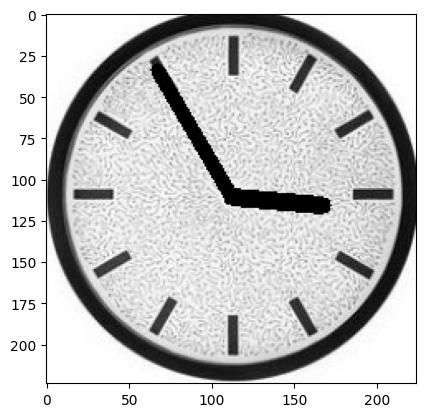

In [13]:
#test loader for saliency map with batch size of 1
test_loader2 = DataLoader(test_dataset, batch_size=1, shuffle=True)
inp = 0
with torch.no_grad():
	for inputs, labels in test_loader2:
		inputs, labels = inputs.to(device), labels.to(device)
		inp = inputs
		outputs = trained_model1(inputs)
		_, predicted = torch.max(outputs.data, 1)
		print(predicted.detach().cpu())
		print(labels)
		break


inp = inp[0].detach().cpu()

plt.imshow(inp.permute(1,2,0))


In [49]:
torch.save(trained_model1.state_dict(), "Naman/resnet_rotated.pth")

In [33]:
labels_dict = {}
for h in range(1, 13):
    for m in range(0, 60, 5):
        cls = h*12 + m//5 - 12
        labels_dict[cls] = [h, m]


[3, 15]


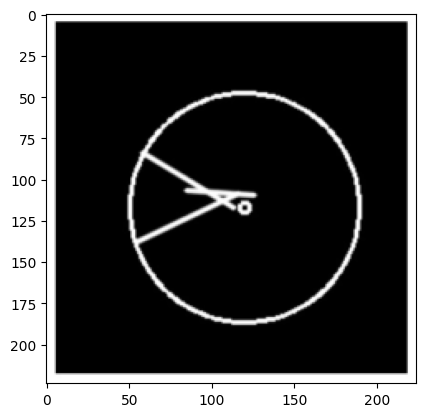

In [43]:
# test_image1 = Image.open("Naman/rotated_clocks/test/1-00/10.jpg")
test_image1 = Image.open("Naman/test_folder/test4.jpeg")

test_image1 = transform(test_image1)
test_image1 = test_image1.unsqueeze(0)
test_image1 = test_image1.to(device)

test_outputs = trained_model1(test_image1)
test_, test_predicted = torch.max(test_outputs.data, 1)

print(labels_dict[test_predicted.detach().cpu().numpy()[0]])
plt.imshow(test_image1[0].detach().cpu().permute(1,2,0))


0